In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from random import randint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


In [2]:
Data_clean = pd.read_excel('data_balanced.xlsx')
#print(data.head())

In [3]:
Data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812 entries, 0 to 1811
Data columns (total 12 columns):
Age                    1812 non-null int64
Amount_netCN           1812 non-null float64
TermOfPaymentDays      1812 non-null int64
GDP by State           1812 non-null int64
Unemployment rate      1812 non-null float64
DefaultStatus          1812 non-null int64
month1                 1812 non-null int64
month2                 1812 non-null int64
month3                 1812 non-null int64
month4                 1812 non-null int64
month5                 1812 non-null int64
Feq_default_ZipCode    1812 non-null float64
dtypes: float64(3), int64(9)
memory usage: 170.0 KB


In [4]:
# Print a null value column array
print(Data_clean.columns[Data_clean.isnull().any()])

Index([], dtype='object')


In [5]:
# Create the X and y data sets
X = Data_clean.loc[:, Data_clean.columns != "DefaultStatus"]
y = Data_clean[["DefaultStatus"]]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

In [6]:
# Train the Xgboost model on the training data
clf_gbt = xgb.XGBClassifier()
scaler = MinMaxScaler()
pipeline = make_pipeline(scaler, clf_gbt)
pipeline.fit(X_train, np.ravel(y_train))


Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method=None,
                               valid

In [7]:
# Predict with a model
gbt_preds = pipeline.predict_proba(X_test)   #gbt_preds is proba

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(gbt_preds[:,1][:], columns = ['prob_default'])
true_df = y_test

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df ], axis = 1))

DefaultStatus  prob_default
0                0      0.002477
1                1      0.985800
2                0      0.002086
3                1      0.878569
4                1      0.984715
..             ...           ...
720              0      0.000571
721              0      0.000173
722              0      0.000465
723              0      0.001296
724              1      0.827452

[725 rows x 2 columns]


In [8]:
gbt_preds

array([[9.9752289e-01, 2.4771153e-03],
       [1.4199555e-02, 9.8580045e-01],
       [9.9791396e-01, 2.0860387e-03],
       ...,
       [9.9953485e-01, 4.6514501e-04],
       [9.9870437e-01, 1.2956267e-03],
       [1.7254776e-01, 8.2745224e-01]], dtype=float32)

In [9]:
# Predict the labels for loan status
#gbt_preds = pipeline.predict(X_test)   #gbt_preds is proba
gbt_preds_df = pd.DataFrame(gbt_preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
gbt_preds_df['DefaultStatus'] = gbt_preds_df['prob_default'].apply(lambda x: 1 if x > 0.17 else 0)  # cutoff 0.12

# Check the values created by the predict method
print(gbt_preds_df['DefaultStatus'].value_counts())

# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds_df['DefaultStatus'], target_names=target_names))
print(roc_auc_score(y_test, gbt_preds_df['DefaultStatus']))

1    426
0    299
Name: DefaultStatus, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.98      0.83      0.90       354
     Default       0.86      0.98      0.92       371

    accuracy                           0.91       725
   macro avg       0.92      0.91      0.91       725
weighted avg       0.92      0.91      0.91       725

0.9057555545403323


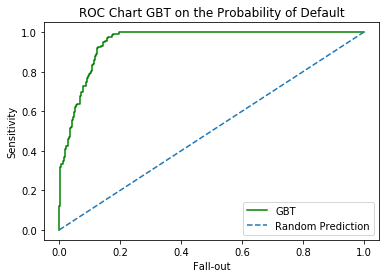

0.9494038101329435


In [10]:
#clf_gbt_preds = gbt_preds2[:,1] 

# ROC chart components
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, gbt_preds[:,1])

# ROC Chart with both
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

# Compute the AUC and store it in a variable
print(roc_auc_score(y_test, gbt_preds[:,1]))

In [11]:
# Create and train the model on the training data
clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

# Print the column importances from the model
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

{'f10': 330, 'f0': 396, 'f7': 8, 'f1': 336, 'f3': 174, 'f4': 136, 'f2': 7, 'f5': 27, 'f6': 19}


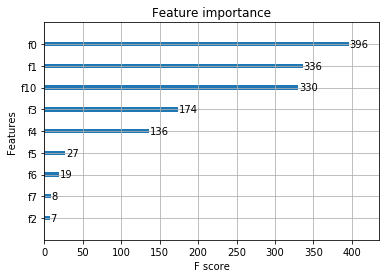

In [12]:
# Plot the column importance for this model
xgb.plot_importance(clf_gbt, importance_type = 'weight')
plt.show()

In [13]:
# #How the model performs over time. How stable the model scores are

# # Set the values for number of folds and stopping iterations
# n_folds = 5
# early_stopping = 10   #stop the run when the scores are not improved. 

# #set params
# params = {'eval_metric': 'auc', 'objective': 'binary:logistic', 'seed': 123}  #'objective': 'binary:logistic' : tell model to predict 0 and 1; 'eval_metric': 'auc' is AUC scorce. 
# # Create the DTrain matrix for XGBoost
# DTrain = xgb.DMatrix(X_train, label = y_train)

# # Create the data frame of cross validations
# cv_df = xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds,
#             early_stopping_rounds=early_stopping)

# # Print the cross validations data frame
# print(cv_df)

In [14]:
# cv_results_big = xgb.cv(params, DTrain, num_boost_round = 30, nfold=10,
#             shuffle = True)

#This is because this much cross-validation can actually cause the model to become overfit. So, there is a limit to how much cross-validation you should to.

In [15]:
# # Print the first five rows of the CV results data frame
# print(cv_results_big.head())

# # Calculate the mean of the test AUC scores
# print(np.mean(cv_results_big["test-auc-mean"]).round(2))

# # Plot the test AUC scores for each iteration
# plt.plot(cv_results_big["test-auc-mean"])
# plt.title('Test AUC Score Over 600 Iterations')
# plt.xlabel('Iteration Number')
# plt.ylabel('Test AUC Score')
# plt.show()

In [16]:
# # Create a gradient boosted tree model using two hyperparameters
# gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7)     #need to tune the best hyperparameters

# # Calculate the cross validation scores for 4 folds
# cv_scores = cross_val_score(gbt, X_train, np.ravel(y_train), cv = 4)

# # Print the cross validation scores
# print(cv_scores)

# # Print the average accuracy and standard deviation of the scores
# print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(),
#                                               cv_scores.std() * 2))

In [17]:

#scaler = MinMaxScaler()
#pipeline = make_pipeline(scaler, clf_gbt)
#pipeline.fit(X_train, np.ravel(y_train))

In [18]:
# Train the Xgboost model on the training data
clf_gbt = xgb.XGBClassifier()
max_depth = [2, 3, 4]
gbm_param_grid = {'learning_rate': [0.14, 0.15, 0.16],
'n_estimators': [ 141, 142, 143], 
'max_depth': max_depth }
#'subsample': [0.3, 0.5, 0.9]
grid_mse = GridSearchCV(estimator=clf_gbt,param_grid=gbm_param_grid,
scoring='roc_auc', cv=5, verbose=1)
grid_mse.fit(X_train, np.ravel(y_train))
print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Best parameters found:  {'learning_rate': 0.14, 'max_depth': 2, 'n_estimators': 141}
Lowest RMSE found:  0.981432340588622
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   11.0s finished


In [19]:
clf_gbt = xgb.XGBClassifier(**grid_mse.best_params_)
clf_gbt.fit(X_train, np.ravel(y_train))

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.14, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=141, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [20]:
gbt_preds = clf_gbt.predict_proba(X_test)

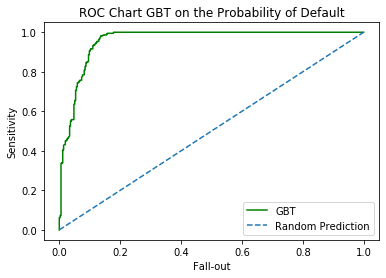

0.9578060517459303


In [21]:
#clf_gbt_preds = gbt_preds2[:,1] 

# ROC chart components
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, gbt_preds[:,1])

# ROC Chart with both
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

# Compute the AUC and store it in a variable
print(roc_auc_score(y_test, gbt_preds[:,1]))

In [22]:
#save model
import pickle
filename = 'XGboost_model.sav'
pickle.dump(clf_gbt, open(filename, 'wb'))

In [23]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict_proba(X_test)

array([[9.9689865e-01, 3.1013433e-03],
       [1.6220629e-02, 9.8377937e-01],
       [9.9890780e-01, 1.0921999e-03],
       ...,
       [9.9983025e-01, 1.6974578e-04],
       [9.9711579e-01, 2.8841894e-03],
       [2.2219390e-01, 7.7780610e-01]], dtype=float32)